In [1]:
gene_familly = "AP2"

In [2]:
# Parameters
gene_familly = "AP2"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA, DNA_MPI
from visualization import VISU, VISUReport
from feature_selection import SelectKFeature

[MacBook-Pro-de-Genereux.local:32059] shmem: mmap: an error occurred while determining whether or not /var/folders/w8/b_cflrn97k9c15rcrn5t8mmr0000gn/T//ompi.MacBook-Pro-de-Genereux.501/jf.0/2864578560/sm_segment.MacBook-Pro-de-Genereux.501.aabe0000.0 could be created.


In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE
gene_info_path = "../data/gene_info_small.json"
trainset_path  = "../data/mix_data/trainset/"
testset_path   = "../data/mix_data/testset/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

# FOCUS ON GENE FAMALLY
gene_dict = gene_info[gene_familly]
df_path = trainset_path+gene_dict['file_code']+".csv"
ts_path = testset_path+gene_dict['file_code']+".csv"

#LOAD DF
USE_FULL_DF = True
if USE_FULL_DF:
    dataset = pd.read_csv(df_path)
    testset = pd.read_csv(ts_path)
else:
    dataset_ = pd.read_csv(df_path)
    testset = pd.read_csv(ts_path)
    r = min(5000/len(dataset_), 1)
    _, dataset = train_test_split(dataset_, test_size=r, stratify=dataset_['class'], random_state=42)

In [6]:
dataset.head()

,Unnamed: 0,id,sequence,length,class
0,5565,Bradi3g12566.1.p,METPLCYDEYSSSSSSSYYVYSDDDRVAYTDQTLVQYGLPQPPLSL...,295,0
1,5090,AT1G03790.1,MDVVCTEHQMRKPTVEIPPRKLLLSSKSFPSDSSSPRSPRKHNWNK...,393,0
2,2236,GSMUA_AchrUn_randomP23040_001,MNMNASDNWLDFSLSQQRCLLEAFSDAPHHHGLSLSLSLSTNAATE...,469,1
3,8018,LPERR05G21720.1,MESMVGVKRKNVVVGGGDGREMLPPSPAPAPVVEFPIGYQSSSPTP...,634,0
4,1489,KHN36319.1,MNIGVPSHLHQTQPSSAAVEAVPPNFYHHTPLHNYGLYYELEGEHV...,548,1


In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7115 entries, 0 to 7114
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  7115 non-null   int64 
 1   id          7115 non-null   object
 2   sequence    7115 non-null   object
 3   length      7115 non-null   int64 
 4   class       7115 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 278.1+ KB


In [8]:
#sns.set(style="whitegrid")
#sns.violinplot(x=dataset.length)
#plt.title("sequence length distribution in test sequences")
#plt.show()

In [9]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [10]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model-ft/"+gene_familly_+"/"+model_name+".keras", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=False
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [11]:
21**2

441

In [12]:
k        = 2
size     = int(len(dataset))
selector = SelectKFeature(dataset, k_feature=200, kmer_size=k, domaine=domaine, sample_size=size, discriminative=None)
mask     = selector.get_feature_mask(method=['f_test', 0.1])

In [13]:
X_train, y_train, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
X_test, y_test, _ = DNA.build_kmer_representation_v2(testset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
X_test.head()

,AA,AC,AE,AF,AH,AI,AK,AN,AQ,AR,...,WT,WY,YC,YD,YE,YK,YL,YM,YR,YW
0,0.013216,0.00000,0.004405,0.000000,0.000000,0.002203,0.004405,0.004405,0.002203,0.006608,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.004405,0.002203,0.000000,0.0
1,0.002433,0.00365,0.006083,0.003650,0.003650,0.002433,0.003650,0.004866,0.002433,0.003650,...,0.001217,0.0,0.0,0.001217,0.000000,0.0,0.004866,0.000000,0.000000,0.0
2,0.003521,0.00000,0.007042,0.003521,0.000000,0.003521,0.003521,0.003521,0.003521,0.003521,...,0.000000,0.0,0.0,0.003521,0.003521,0.0,0.000000,0.000000,0.000000,0.0
3,0.004566,0.00000,0.009132,0.004566,0.004566,0.000000,0.000000,0.004566,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.004566,0.000000,0.004566,0.0
4,0.008798,0.00000,0.005865,0.005865,0.000000,0.002933,0.000000,0.002933,0.008798,0.005865,...,0.000000,0.0,0.0,0.005865,0.000000,0.0,0.002933,0.000000,0.000000,0.0


In [14]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (7115, 200)
X_test: (1779, 200)
y_train: (7115,)
y_test: (1779,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [15]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        51,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,721 (370.00 KB)

 Trainable params: 94,721 (370.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1:19 902ms/step - accuracy: 0.4531 - loss: 0.6931

25/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6562 - loss: 0.6875    

47/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7305 - loss: 0.6651

73/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7775 - loss: 0.6087

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7977 - loss: 0.5717 - val_accuracy: 0.9529 - val_loss: 0.1237


Epoch 2/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9531 - loss: 0.1693

30/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9462 - loss: 0.1698 

60/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9517 - loss: 0.1492

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9536 - loss: 0.1405

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9537 - loss: 0.1401 - val_accuracy: 0.9585 - val_loss: 0.1160


Epoch 3/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8906 - loss: 0.3017

27/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9584 - loss: 0.1223 

51/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9592 - loss: 0.1209

78/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9602 - loss: 0.1175

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9605 - loss: 0.1160 - val_accuracy: 0.9635 - val_loss: 0.0971


Epoch 4/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.0148

25/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9674 - loss: 0.0795 

51/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9667 - loss: 0.0829

76/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9660 - loss: 0.0853

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9656 - loss: 0.0865 - val_accuracy: 0.9649 - val_loss: 0.0960


Epoch 5/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9688 - loss: 0.0783

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9606 - loss: 0.1054 

53/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9638 - loss: 0.0985

79/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9656 - loss: 0.0943

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9661 - loss: 0.0934 - val_accuracy: 0.9670 - val_loss: 0.0877


Epoch 6/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9688 - loss: 0.0915

28/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9660 - loss: 0.0753 

54/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9682 - loss: 0.0743

78/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9688 - loss: 0.0748

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9689 - loss: 0.0749 - val_accuracy: 0.9684 - val_loss: 0.0817


Epoch 7/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9844 - loss: 0.0408

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9767 - loss: 0.0664 

54/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9762 - loss: 0.0677

79/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9756 - loss: 0.0690

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9755 - loss: 0.0691 - val_accuracy: 0.9670 - val_loss: 0.0890


Epoch 8/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9844 - loss: 0.0861

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9716 - loss: 0.0733 

54/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9728 - loss: 0.0683

82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9732 - loss: 0.0670

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9732 - loss: 0.0670 - val_accuracy: 0.9698 - val_loss: 0.0775


Epoch 9/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9688 - loss: 0.0780

27/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9748 - loss: 0.0625 

52/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9754 - loss: 0.0609

79/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9750 - loss: 0.0613

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9750 - loss: 0.0616 - val_accuracy: 0.9670 - val_loss: 0.0812


Epoch 10/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9688 - loss: 0.0463

27/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9753 - loss: 0.0505 

53/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9761 - loss: 0.0521

76/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9764 - loss: 0.0534

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9765 - loss: 0.0539 - val_accuracy: 0.9726 - val_loss: 0.0726


Epoch 11/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9531 - loss: 0.0896

25/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9703 - loss: 0.0633 

51/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9740 - loss: 0.0593

77/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9758 - loss: 0.0570

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9763 - loss: 0.0560 - val_accuracy: 0.9719 - val_loss: 0.0737


Epoch 12/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9844 - loss: 0.0355

27/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9818 - loss: 0.0452 

53/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9834 - loss: 0.0428

81/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9842 - loss: 0.0419

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9842 - loss: 0.0420 - val_accuracy: 0.9719 - val_loss: 0.0743


Epoch 13/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0336

27/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9877 - loss: 0.0366 

52/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9863 - loss: 0.0393

78/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9858 - loss: 0.0399

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9859 - loss: 0.0397 - val_accuracy: 0.9705 - val_loss: 0.0763


Epoch 14/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0139

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9848 - loss: 0.0403 

53/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9848 - loss: 0.0415

76/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9840 - loss: 0.0432

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9837 - loss: 0.0437 - val_accuracy: 0.9691 - val_loss: 0.0724


Epoch 15/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 0.0152

18/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9987 - loss: 0.0144 

42/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9921 - loss: 0.0266

66/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9903 - loss: 0.0296

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9891 - loss: 0.0316 - val_accuracy: 0.9726 - val_loss: 0.0677


Epoch 16/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9844 - loss: 0.0353

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9811 - loss: 0.0367 

51/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9837 - loss: 0.0344

77/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9850 - loss: 0.0328

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9855 - loss: 0.0321 - val_accuracy: 0.9775 - val_loss: 0.0710


Epoch 17/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0022

28/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9934 - loss: 0.0169 

53/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9916 - loss: 0.0222

78/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9912 - loss: 0.0239

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9912 - loss: 0.0242 - val_accuracy: 0.9740 - val_loss: 0.0773


Epoch 18/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.0082

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9917 - loss: 0.0204 

51/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9923 - loss: 0.0201

77/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9923 - loss: 0.0206

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9924 - loss: 0.0206 - val_accuracy: 0.9754 - val_loss: 0.0739


Epoch 19/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0059

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9955 - loss: 0.0100 

48/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9945 - loss: 0.0126

75/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9941 - loss: 0.0139

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9939 - loss: 0.0147 - val_accuracy: 0.9719 - val_loss: 0.0800


Epoch 20/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9688 - loss: 0.0625

28/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9870 - loss: 0.0303 

57/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9883 - loss: 0.0278

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9891 - loss: 0.0262

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9892 - loss: 0.0260 - val_accuracy: 0.9712 - val_loss: 0.0799


Epoch 21/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.0125

24/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9981 - loss: 0.0073 

53/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9968 - loss: 0.0095

79/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9965 - loss: 0.0102

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9964 - loss: 0.0106 - val_accuracy: 0.9698 - val_loss: 0.0867


Epoch 22/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0149

25/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9945 - loss: 0.0143 

49/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9947 - loss: 0.0142

75/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9944 - loss: 0.0156

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9942 - loss: 0.0164 - val_accuracy: 0.9635 - val_loss: 0.1126


Epoch 23/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0067

28/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9935 - loss: 0.0169 

54/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9936 - loss: 0.0171

82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9939 - loss: 0.0165

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9941 - loss: 0.0163 - val_accuracy: 0.9754 - val_loss: 0.0872


Epoch 24/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0194

22/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9964 - loss: 0.0083 

48/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9969 - loss: 0.0094

73/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9963 - loss: 0.0117

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9960 - loss: 0.0126 - val_accuracy: 0.9599 - val_loss: 0.1319


Epoch 25/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0011

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9941 - loss: 0.0154 

51/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9927 - loss: 0.0186

76/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9929 - loss: 0.0186

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9930 - loss: 0.0183 - val_accuracy: 0.9719 - val_loss: 0.0977


Epoch 26/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.0029

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0059 

53/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0063

81/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0068

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0069 - val_accuracy: 0.9740 - val_loss: 0.0847



[Train Accuracy: 99.75% - Test Accuracy: 97.13%]


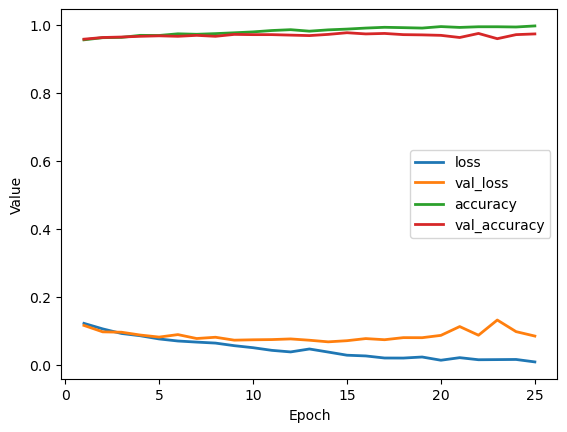

In [16]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [17]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k2, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/56 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step


 1/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [18]:
21**3

9261

In [19]:
k        = 3
size     = int(len(dataset))
selector = SelectKFeature(dataset, k_feature=1000, kmer_size=k, domaine=domaine, sample_size=size, discriminative=None)
mask     = selector.get_feature_mask(method=['rf', 0.1])

In [20]:
X_train, y_train, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
X_test, y_test, _ = DNA.build_kmer_representation_v2(testset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
X_test.head()

,AYD,YLG,RGV,EAH,FRG,KYW,GRW,TGR,SGF,YWG,...,FEP,LRK,GGN,DTR,GGV,LPQ,KPL,ISM,NNI,YLS
0,0.0,0.002208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.001218,0.0,0.000000,0.0,0.001218,0.000000,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.003534,0.0,0.000000,0.000000,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.004587,0.0,0.000000,0.0,0.000000,0.004587,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.002941,0.0,0.002941,0.0,0.000000,0.000000,0.0,0.0,0.0


In [21]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (7115, 1000)
X_test: (1779, 1000)
y_train: (7115,)
y_test: (1779,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [22]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 256)            │       256,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 299,521 (1.14 MB)

 Trainable params: 299,521 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1:04 729ms/step - accuracy: 0.4531 - loss: 0.6931

13/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5224 - loss: 0.6913    

28/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6191 - loss: 0.6831

43/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6829 - loss: 0.6619

57/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7240 - loss: 0.6292

69/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7500 - loss: 0.5981

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7734 - loss: 0.5631

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7831 - loss: 0.5467 - val_accuracy: 0.9635 - val_loss: 0.0885


Epoch 2/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9844 - loss: 0.0487

10/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9879 - loss: 0.0465 

20/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9834 - loss: 0.0542

32/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9805 - loss: 0.0598

45/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9797 - loss: 0.0616

56/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9792 - loss: 0.0630

66/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9789 - loss: 0.0638

78/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9787 - loss: 0.0643

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9786 - loss: 0.0648 - val_accuracy: 0.9733 - val_loss: 0.0818


Epoch 3/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9844 - loss: 0.0728

10/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9784 - loss: 0.0636 

20/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9803 - loss: 0.0583

32/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9820 - loss: 0.0538

44/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9828 - loss: 0.0515

56/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9831 - loss: 0.0506

69/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9833 - loss: 0.0499

81/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9836 - loss: 0.0493

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9838 - loss: 0.0489 - val_accuracy: 0.9691 - val_loss: 0.0800


Epoch 4/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9688 - loss: 0.0825

12/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9891 - loss: 0.0412 

24/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9898 - loss: 0.0366

36/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9894 - loss: 0.0363

48/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9891 - loss: 0.0363

59/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9891 - loss: 0.0358

71/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9890 - loss: 0.0353

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9889 - loss: 0.0348

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9888 - loss: 0.0347 - val_accuracy: 0.9754 - val_loss: 0.0816


Epoch 5/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 0.0068

13/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9972 - loss: 0.0183 

25/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9960 - loss: 0.0199

35/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9958 - loss: 0.0196

47/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9949 - loss: 0.0212

58/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9942 - loss: 0.0223

70/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9936 - loss: 0.0232

82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9932 - loss: 0.0239

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9930 - loss: 0.0243 - val_accuracy: 0.9754 - val_loss: 0.0786


Epoch 6/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 0.0044

13/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9933 - loss: 0.0357 

25/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9927 - loss: 0.0315

40/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9924 - loss: 0.0288

52/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9926 - loss: 0.0271

65/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9929 - loss: 0.0254

78/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9932 - loss: 0.0242

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9933 - loss: 0.0237

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9933 - loss: 0.0236 - val_accuracy: 0.9691 - val_loss: 0.1110


Epoch 7/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 0.0019

12/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9932 - loss: 0.0233 

23/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9947 - loss: 0.0205

37/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9953 - loss: 0.0182

50/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9956 - loss: 0.0169

63/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9957 - loss: 0.0163

74/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9957 - loss: 0.0165

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9954 - loss: 0.0168

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9953 - loss: 0.0170 - val_accuracy: 0.9691 - val_loss: 0.1052


Epoch 8/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 0.0052

13/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9884 - loss: 0.0273 

22/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9881 - loss: 0.0288

32/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9878 - loss: 0.0299

43/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9881 - loss: 0.0296

54/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9885 - loss: 0.0287

65/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9888 - loss: 0.0279

76/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9891 - loss: 0.0272

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9894 - loss: 0.0267

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9895 - loss: 0.0265 - val_accuracy: 0.9747 - val_loss: 0.0918


Epoch 9/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 0.0069

11/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0041 

20/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0046

31/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0047

40/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9997 - loss: 0.0052

52/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9993 - loss: 0.0059

62/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9990 - loss: 0.0064

73/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9988 - loss: 0.0067

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9986 - loss: 0.0071

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9985 - loss: 0.0074 - val_accuracy: 0.9585 - val_loss: 0.1511


Epoch 10/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9688 - loss: 0.0575

10/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9886 - loss: 0.0225 

21/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9922 - loss: 0.0179

33/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9940 - loss: 0.0152

44/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9947 - loss: 0.0137

55/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9952 - loss: 0.0127

65/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9955 - loss: 0.0120

76/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9958 - loss: 0.0114

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9960 - loss: 0.0111

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9960 - loss: 0.0109 - val_accuracy: 0.9740 - val_loss: 0.1126


Epoch 11/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9688 - loss: 0.1290

11/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9914 - loss: 0.0366 

21/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9946 - loss: 0.0238

31/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9959 - loss: 0.0184

42/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9968 - loss: 0.0153

51/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9971 - loss: 0.0138

61/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9973 - loss: 0.0127

71/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9973 - loss: 0.0120

81/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9974 - loss: 0.0115

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9973 - loss: 0.0112 - val_accuracy: 0.9747 - val_loss: 0.1075


Epoch 12/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 8.1840e-04

11/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0023     

23/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9998 - loss: 0.0025

33/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9997 - loss: 0.0027

43/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9996 - loss: 0.0032

53/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9995 - loss: 0.0035

64/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9995 - loss: 0.0039

74/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9994 - loss: 0.0041

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9993 - loss: 0.0044

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9992 - loss: 0.0047 - val_accuracy: 0.9712 - val_loss: 0.1171


Epoch 13/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.0000 - loss: 0.0055

11/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9948 - loss: 0.0110 

21/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9959 - loss: 0.0093

33/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9967 - loss: 0.0083

46/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9970 - loss: 0.0082

56/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9973 - loss: 0.0080

67/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9975 - loss: 0.0076

76/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9977 - loss: 0.0074

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9978 - loss: 0.0071

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9978 - loss: 0.0071 - val_accuracy: 0.9768 - val_loss: 0.1131


Epoch 14/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 2.4128e-04

11/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9983 - loss: 0.0030     

21/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9986 - loss: 0.0029

32/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9987 - loss: 0.0029

42/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9985 - loss: 0.0034

53/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9985 - loss: 0.0038

63/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9984 - loss: 0.0041

72/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9983 - loss: 0.0044

81/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9983 - loss: 0.0046

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9983 - loss: 0.0048 - val_accuracy: 0.9719 - val_loss: 0.1195


Epoch 15/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 4.8082e-04

 9/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0012     

19/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0011

29/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0011

39/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0011

49/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0010

61/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0010

71/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0010

82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0010

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9684 - val_loss: 0.1353


Epoch 16/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 7.7383e-04

11/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9939 - loss: 0.0126     

21/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9939 - loss: 0.0137

31/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9944 - loss: 0.0129

42/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9948 - loss: 0.0122

54/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9951 - loss: 0.0114

67/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9954 - loss: 0.0108

78/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9956 - loss: 0.0103

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9958 - loss: 0.0099 - val_accuracy: 0.9782 - val_loss: 0.1165


Epoch 17/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 8.3033e-05

13/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9989 - loss: 0.0050     

25/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9986 - loss: 0.0054

36/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9985 - loss: 0.0054

46/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9985 - loss: 0.0053

57/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9986 - loss: 0.0050

67/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9986 - loss: 0.0047

77/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9987 - loss: 0.0045

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9988 - loss: 0.0043

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9988 - loss: 0.0043 - val_accuracy: 0.9663 - val_loss: 0.1301


Epoch 18/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 9.3431e-04

15/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 7.5294e-04 

27/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 7.1008e-04

36/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 6.7733e-04

47/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 6.5170e-04

58/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 6.3740e-04

68/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 6.5030e-04

78/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9999 - loss: 6.6190e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9999 - loss: 6.6404e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9999 - loss: 6.6396e-04 - val_accuracy: 0.9733 - val_loss: 0.1321


Epoch 19/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 0.0011

11/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 4.4545e-04

20/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.6636e-04

30/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.6170e-04

41/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.4843e-04

52/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.4313e-04

61/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.3711e-04

75/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.2927e-04

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.2418e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 3.2129e-04 - val_accuracy: 0.9740 - val_loss: 0.1404


Epoch 20/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.0000 - loss: 2.4555e-04

11/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.6788e-04 

21/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.7441e-04

31/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.6266e-04

40/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.5547e-04

51/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.4661e-04

61/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.3974e-04

72/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.3330e-04

82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.2918e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 2.2676e-04 - val_accuracy: 0.9705 - val_loss: 0.1483


Epoch 21/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.0000 - loss: 1.9229e-04

10/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.9790e-04 

22/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.7319e-04

34/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.6166e-04

44/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.5620e-04

55/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.5127e-04

68/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.4830e-04

81/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.4622e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.4459e-04 - val_accuracy: 0.9754 - val_loss: 0.1503


Epoch 22/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 2.8486e-05

10/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1189e-04 

20/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.6618e-04

30/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.7584e-04

40/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.7246e-04

53/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.6334e-04

63/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.5577e-04

73/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.4950e-04

82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.4472e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.4160e-04 - val_accuracy: 0.9740 - val_loss: 0.1555


Epoch 23/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 9.9775e-06

13/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 9.7704e-05 

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 9.6453e-05

41/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.0313e-04

52/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.0571e-04

62/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.0530e-04

75/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.0392e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.0256e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.0252e-04 - val_accuracy: 0.9754 - val_loss: 0.1589


Epoch 24/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 2.2897e-05

12/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 7.4982e-05 

25/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 7.9625e-05

38/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 8.6129e-05

51/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 9.2199e-05

63/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 9.6319e-05

74/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 9.7939e-05

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 9.8456e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 9.8542e-05 - val_accuracy: 0.9747 - val_loss: 0.1622


Epoch 25/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 4.5136e-05

13/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 5.7506e-05 

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 5.1883e-05

38/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 6.4367e-05

53/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 9.3611e-05

66/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.0452e-04

78/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.1703e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.2491e-04 - val_accuracy: 0.9691 - val_loss: 0.1674


Epoch 26/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 4.6917e-05

13/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.7590e-04 

25/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.9587e-04

37/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.0607e-04

49/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.0056e-04

62/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.9108e-04

76/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.8067e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.7264e-04 - val_accuracy: 0.9754 - val_loss: 0.1624



[Train Accuracy: 100.00% - Test Accuracy: 97.25%]


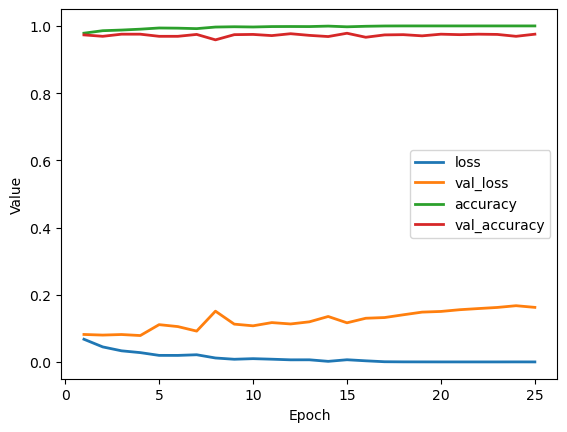

In [23]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [24]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k3, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/56 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step

51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 1/56 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

41/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [25]:
21**4

194481

In [26]:
k        = 4
size     = int(len(dataset))
selector = SelectKFeature(dataset, k_feature=1000, kmer_size=k, domaine=domaine, sample_size=size, discriminative=None)
mask     = selector.get_feature_mask(method=['f_test', 0.1])

In [27]:
X_train, y_train, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
X_test, y_test, _ = DNA.build_kmer_representation_v2(testset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y) #, random_state=42
X_test.head()

,AAAH,AAAR,AAAS,AAEA,AAHA,AAIE,AAIK,AAIR,AAKR,AALK,...,YRRT,YSTQ,YVAH,YVYL,YWGA,YWGP,YWGQ,YWGT,YWKA,YYRC
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [29]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 256)            │       256,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 297,473 (1.13 MB)

 Trainable params: 297,473 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 57s 655ms/step - accuracy: 0.5156 - loss: 0.6930

20/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6544 - loss: 0.6888   

44/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7570 - loss: 0.6624

67/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8037 - loss: 0.6106

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8313 - loss: 0.5585 - val_accuracy: 0.9613 - val_loss: 0.1255


Epoch 2/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9688 - loss: 0.1307

22/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9582 - loss: 0.1295 

42/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9575 - loss: 0.1281

62/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9577 - loss: 0.1268

82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9581 - loss: 0.1253

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9583 - loss: 0.1244 - val_accuracy: 0.9635 - val_loss: 0.0978


Epoch 3/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9688 - loss: 0.0977

21/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9630 - loss: 0.0960 

42/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9610 - loss: 0.1027

62/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9611 - loss: 0.1036

81/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9613 - loss: 0.1038

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9613 - loss: 0.1040 - val_accuracy: 0.9606 - val_loss: 0.1195


Epoch 4/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.0887

20/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9678 - loss: 0.1089 

39/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9650 - loss: 0.1058

59/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9642 - loss: 0.1049

79/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9640 - loss: 0.1039

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9640 - loss: 0.1033 - val_accuracy: 0.9635 - val_loss: 0.0965


Epoch 5/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9688 - loss: 0.0986

20/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9627 - loss: 0.1047 

40/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9629 - loss: 0.0993

59/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9630 - loss: 0.0973

78/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9632 - loss: 0.0956

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9633 - loss: 0.0948 - val_accuracy: 0.9628 - val_loss: 0.0897


Epoch 6/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9375 - loss: 0.1431

21/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9751 - loss: 0.0732 

42/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9729 - loss: 0.0766

62/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9705 - loss: 0.0790

82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9694 - loss: 0.0804

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9691 - loss: 0.0807 - val_accuracy: 0.9677 - val_loss: 0.0795


Epoch 7/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9531 - loss: 0.1143

21/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9647 - loss: 0.0958 

40/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9662 - loss: 0.0960

59/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9675 - loss: 0.0932

78/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9685 - loss: 0.0905

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9689 - loss: 0.0891 - val_accuracy: 0.9677 - val_loss: 0.0866


Epoch 8/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9688 - loss: 0.0663

19/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9637 - loss: 0.0830 

38/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9659 - loss: 0.0775

58/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9679 - loss: 0.0738

78/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9693 - loss: 0.0714

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9699 - loss: 0.0703 - val_accuracy: 0.9698 - val_loss: 0.0754


Epoch 9/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9844 - loss: 0.0523

20/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9793 - loss: 0.0576 

40/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9793 - loss: 0.0569

60/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9785 - loss: 0.0589

80/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9778 - loss: 0.0601

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9776 - loss: 0.0604 - val_accuracy: 0.9726 - val_loss: 0.0694


Epoch 10/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9219 - loss: 0.1152

18/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9652 - loss: 0.0761 

37/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9700 - loss: 0.0682

56/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9727 - loss: 0.0637

75/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9741 - loss: 0.0613

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9748 - loss: 0.0602 - val_accuracy: 0.9768 - val_loss: 0.0675


Epoch 11/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.0385

19/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9785 - loss: 0.0568 

39/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9801 - loss: 0.0542

58/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9804 - loss: 0.0541

78/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9803 - loss: 0.0540

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9804 - loss: 0.0537 - val_accuracy: 0.9740 - val_loss: 0.0747


Epoch 12/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9688 - loss: 0.0759

20/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9845 - loss: 0.0472 

40/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9838 - loss: 0.0473

60/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9835 - loss: 0.0471

80/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9834 - loss: 0.0474

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9832 - loss: 0.0476 - val_accuracy: 0.9740 - val_loss: 0.0697


Epoch 13/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9688 - loss: 0.0730

20/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9860 - loss: 0.0412 

40/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9859 - loss: 0.0394

60/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9852 - loss: 0.0400

79/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9851 - loss: 0.0401

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9850 - loss: 0.0402 - val_accuracy: 0.9733 - val_loss: 0.0706


Epoch 14/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9531 - loss: 0.0747

20/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9781 - loss: 0.0529 

40/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9811 - loss: 0.0483

59/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9824 - loss: 0.0456

78/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9830 - loss: 0.0446

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9832 - loss: 0.0443 - val_accuracy: 0.9585 - val_loss: 0.1246


Epoch 15/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9531 - loss: 0.0697

20/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9701 - loss: 0.0681 

39/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9744 - loss: 0.0586

58/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9764 - loss: 0.0538

78/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9779 - loss: 0.0508

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9783 - loss: 0.0504 - val_accuracy: 0.9663 - val_loss: 0.0804


Epoch 16/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9688 - loss: 0.0664

20/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9838 - loss: 0.0441 

39/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9847 - loss: 0.0415

59/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9848 - loss: 0.0404

78/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9848 - loss: 0.0406

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9847 - loss: 0.0410 - val_accuracy: 0.9726 - val_loss: 0.0745


Epoch 17/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0241

21/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9898 - loss: 0.0350 

41/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9878 - loss: 0.0377

62/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9860 - loss: 0.0410

82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9854 - loss: 0.0417

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9853 - loss: 0.0419 - val_accuracy: 0.9754 - val_loss: 0.0722


Epoch 18/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 0.0094

20/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9870 - loss: 0.0294 

40/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9879 - loss: 0.0290

59/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9883 - loss: 0.0287

79/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9885 - loss: 0.0292

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9885 - loss: 0.0294 - val_accuracy: 0.9740 - val_loss: 0.0756


Epoch 19/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9844 - loss: 0.0277

20/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9911 - loss: 0.0264 

39/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9901 - loss: 0.0287

58/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9899 - loss: 0.0298

76/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9896 - loss: 0.0305

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9892 - loss: 0.0313 - val_accuracy: 0.9691 - val_loss: 0.1203


Epoch 20/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9375 - loss: 0.1112

20/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9816 - loss: 0.0422 

40/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9849 - loss: 0.0371

59/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9857 - loss: 0.0350

78/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9860 - loss: 0.0341

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9861 - loss: 0.0337 - val_accuracy: 0.9733 - val_loss: 0.0860



[Train Accuracy: 98.72% - Test Accuracy: 97.81%]


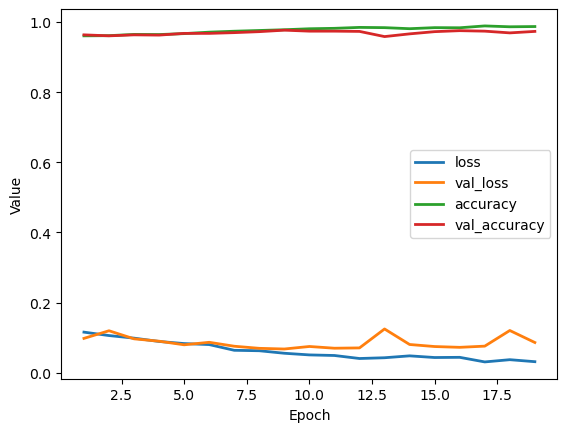

In [30]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [31]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k4, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/56 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 1/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step


In [32]:
#report.save()

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [33]:
21**5

4084101

In [34]:
k        = 5
size     = int(len(dataset))
selector = SelectKFeature(dataset, k_feature=1000, kmer_size=k, domaine=domaine, sample_size=min(1300/len(dataset), 1), discriminative=None)
mask     = selector.get_feature_mask(method=['f_test', 0.00001]);

In [35]:
k = 5
X_train, y_train, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
X_test, y_test, _ = DNA.build_kmer_representation_v2(testset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y) #, random_state=42
X_test.head()

,AAARA,AAASS,AAEAY,AAIEY,AAIKC,AAIKF,AAIKY,AAKRL,AALKY,AARAY,...,YRGVT,YRRTG,YSTQE,YVAHL,YVYLG,YWGPG,YWGPS,YWGPT,YWGTS,YWGTT
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [37]:
name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 512)            │       512,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 586,497 (2.24 MB)

 Trainable params: 586,497 (2.24 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 58s 666ms/step - accuracy: 0.6875 - loss: 0.6930

15/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5388 - loss: 0.6910   

29/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5362 - loss: 0.6828

42/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5661 - loss: 0.6663

57/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6078 - loss: 0.6372

71/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6413 - loss: 0.6059

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6708 - loss: 0.5738

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6777 - loss: 0.5656 - val_accuracy: 0.9522 - val_loss: 0.1492


Epoch 2/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9375 - loss: 0.2370

16/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9441 - loss: 0.1951 

29/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9480 - loss: 0.1817

42/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9509 - loss: 0.1716

55/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9526 - loss: 0.1665

68/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9537 - loss: 0.1631

80/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9545 - loss: 0.1603

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9552 - loss: 0.1581 - val_accuracy: 0.9599 - val_loss: 0.1253


Epoch 3/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9844 - loss: 0.1047

14/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9594 - loss: 0.1386 

27/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9606 - loss: 0.1375

41/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9606 - loss: 0.1363

54/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9608 - loss: 0.1346

66/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9610 - loss: 0.1332

79/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9612 - loss: 0.1321

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9613 - loss: 0.1316 - val_accuracy: 0.9550 - val_loss: 0.1566


Epoch 4/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9531 - loss: 0.1710

14/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9513 - loss: 0.1633 

27/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9551 - loss: 0.1479

40/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9574 - loss: 0.1392

53/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9585 - loss: 0.1351

66/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9591 - loss: 0.1329

79/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9596 - loss: 0.1314

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9600 - loss: 0.1305 - val_accuracy: 0.9585 - val_loss: 0.1390


Epoch 5/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9531 - loss: 0.1511

14/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9706 - loss: 0.1041 

27/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9710 - loss: 0.1021

40/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9701 - loss: 0.1036

54/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9688 - loss: 0.1066

67/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9677 - loss: 0.1091

79/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9671 - loss: 0.1106

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9666 - loss: 0.1117 - val_accuracy: 0.9585 - val_loss: 0.1253


Epoch 6/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9375 - loss: 0.1689

13/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9579 - loss: 0.1311 

27/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9618 - loss: 0.1184

40/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9630 - loss: 0.1135

52/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9633 - loss: 0.1117

65/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9636 - loss: 0.1107

78/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9636 - loss: 0.1105

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9636 - loss: 0.1106 - val_accuracy: 0.9613 - val_loss: 0.1174


Epoch 7/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9375 - loss: 0.1632

14/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9467 - loss: 0.1462 

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9509 - loss: 0.1392

38/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9545 - loss: 0.1325

51/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9570 - loss: 0.1269

63/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9586 - loss: 0.1233

76/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9596 - loss: 0.1213

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9603 - loss: 0.1199

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9603 - loss: 0.1198 - val_accuracy: 0.9592 - val_loss: 0.1251


Epoch 8/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9688 - loss: 0.1330

13/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9718 - loss: 0.1037 

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9690 - loss: 0.1081

40/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9681 - loss: 0.1089

53/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9677 - loss: 0.1087

65/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9676 - loss: 0.1085

77/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9673 - loss: 0.1086

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9672 - loss: 0.1084

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9672 - loss: 0.1084 - val_accuracy: 0.9585 - val_loss: 0.1338


Epoch 9/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9688 - loss: 0.0513

13/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9578 - loss: 0.1268 

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9578 - loss: 0.1288

39/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9575 - loss: 0.1293

51/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9584 - loss: 0.1270

63/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9595 - loss: 0.1241

75/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9603 - loss: 0.1217

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9610 - loss: 0.1195

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9612 - loss: 0.1192 - val_accuracy: 0.9585 - val_loss: 0.1343


Epoch 10/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 0.0277

13/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9805 - loss: 0.0592 

25/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9771 - loss: 0.0688

37/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9752 - loss: 0.0738

50/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9737 - loss: 0.0774

62/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9726 - loss: 0.0810

74/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9718 - loss: 0.0837

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9710 - loss: 0.0861

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9708 - loss: 0.0867 - val_accuracy: 0.9599 - val_loss: 0.1208


Epoch 11/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9844 - loss: 0.0793

13/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9651 - loss: 0.1144 

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9645 - loss: 0.1116

39/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9645 - loss: 0.1108

52/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9647 - loss: 0.1093

64/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9648 - loss: 0.1078

77/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9653 - loss: 0.1060

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9657 - loss: 0.1048 - val_accuracy: 0.9635 - val_loss: 0.1160


Epoch 12/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 0.0687

13/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9791 - loss: 0.0828 

25/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9750 - loss: 0.0905

38/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9734 - loss: 0.0935

51/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9719 - loss: 0.0965

64/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9707 - loss: 0.0986

77/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9699 - loss: 0.0996

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9694 - loss: 0.0999

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9694 - loss: 0.0999 - val_accuracy: 0.9606 - val_loss: 0.1203


Epoch 13/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9531 - loss: 0.1103

13/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9610 - loss: 0.1166 

25/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9645 - loss: 0.1114

38/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9670 - loss: 0.1060

51/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9674 - loss: 0.1044

63/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9677 - loss: 0.1030

75/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9679 - loss: 0.1022

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9679 - loss: 0.1017

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9680 - loss: 0.1016 - val_accuracy: 0.9585 - val_loss: 0.1290


Epoch 14/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9688 - loss: 0.0878

14/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9741 - loss: 0.0855 

27/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9721 - loss: 0.0930

39/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9713 - loss: 0.0948

51/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9710 - loss: 0.0950

64/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9707 - loss: 0.0956

76/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9707 - loss: 0.0952

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9707 - loss: 0.0948

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9707 - loss: 0.0947 - val_accuracy: 0.9613 - val_loss: 0.1223


Epoch 15/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9688 - loss: 0.1275

14/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9674 - loss: 0.1202 

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9679 - loss: 0.1140

39/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9686 - loss: 0.1087

52/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9692 - loss: 0.1052

65/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9693 - loss: 0.1031

78/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9694 - loss: 0.1018

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9695 - loss: 0.1009 - val_accuracy: 0.9613 - val_loss: 0.1147


Epoch 16/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9688 - loss: 0.0847

14/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9756 - loss: 0.0805 

27/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9744 - loss: 0.0823

39/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9741 - loss: 0.0826

52/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9739 - loss: 0.0836

65/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9736 - loss: 0.0849

77/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9733 - loss: 0.0859

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9729 - loss: 0.0872 - val_accuracy: 0.9613 - val_loss: 0.1173


Epoch 17/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9844 - loss: 0.0610

13/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9791 - loss: 0.0733 

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9764 - loss: 0.0778

39/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9753 - loss: 0.0804

51/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9745 - loss: 0.0823

63/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9736 - loss: 0.0845

76/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9732 - loss: 0.0858

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9728 - loss: 0.0869

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9727 - loss: 0.0870 - val_accuracy: 0.9642 - val_loss: 0.1088


Epoch 18/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9844 - loss: 0.0745

14/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9786 - loss: 0.0818 

27/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9771 - loss: 0.0827

40/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9748 - loss: 0.0846

53/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9737 - loss: 0.0854

66/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9729 - loss: 0.0857

79/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9726 - loss: 0.0858

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9724 - loss: 0.0860 - val_accuracy: 0.9606 - val_loss: 0.1271


Epoch 19/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9531 - loss: 0.1331

13/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9725 - loss: 0.0851 

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9723 - loss: 0.0849

39/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9720 - loss: 0.0846

52/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9717 - loss: 0.0850

65/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9713 - loss: 0.0859

78/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9712 - loss: 0.0864

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9711 - loss: 0.0870 - val_accuracy: 0.9592 - val_loss: 0.1303


Epoch 20/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 0.0131

14/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9713 - loss: 0.1077 

27/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9713 - loss: 0.1039

40/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9717 - loss: 0.1004

53/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9717 - loss: 0.0983

66/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9719 - loss: 0.0960

79/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9720 - loss: 0.0944

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9720 - loss: 0.0937 - val_accuracy: 0.9621 - val_loss: 0.1239


Epoch 21/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9375 - loss: 0.2372

14/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9622 - loss: 0.1236 

27/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9645 - loss: 0.1093

39/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9656 - loss: 0.1043

53/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9668 - loss: 0.1000

65/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9673 - loss: 0.0988

77/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9678 - loss: 0.0980

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9682 - loss: 0.0971 - val_accuracy: 0.9642 - val_loss: 0.1102


Epoch 22/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9688 - loss: 0.0656

14/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9722 - loss: 0.0735 

27/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9714 - loss: 0.0771

40/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9706 - loss: 0.0818

53/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9703 - loss: 0.0841

66/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9705 - loss: 0.0846

79/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9707 - loss: 0.0847

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9708 - loss: 0.0849 - val_accuracy: 0.9621 - val_loss: 0.1220


Epoch 23/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9688 - loss: 0.1234

14/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9616 - loss: 0.1164 

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9636 - loss: 0.1090

39/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9654 - loss: 0.1039

51/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9669 - loss: 0.1002

64/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9681 - loss: 0.0969

77/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9687 - loss: 0.0948

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9692 - loss: 0.0931

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9692 - loss: 0.0930 - val_accuracy: 0.9578 - val_loss: 0.1106


Epoch 24/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 0.0440

13/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9679 - loss: 0.1017 

25/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9685 - loss: 0.0987

38/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9694 - loss: 0.0949

50/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9700 - loss: 0.0925

63/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9709 - loss: 0.0902

76/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9713 - loss: 0.0890

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9715 - loss: 0.0881

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9715 - loss: 0.0881 - val_accuracy: 0.9635 - val_loss: 0.1155


Epoch 25/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9531 - loss: 0.0959

14/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9667 - loss: 0.0923 

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9704 - loss: 0.0859

38/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9725 - loss: 0.0809

51/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9733 - loss: 0.0783

64/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9731 - loss: 0.0787

76/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9728 - loss: 0.0795

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9726 - loss: 0.0801

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9726 - loss: 0.0802 - val_accuracy: 0.9642 - val_loss: 0.1060


Epoch 26/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9844 - loss: 0.0614

13/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9675 - loss: 0.0816 

25/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9697 - loss: 0.0816

38/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9696 - loss: 0.0831

50/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9696 - loss: 0.0839

63/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9700 - loss: 0.0833

76/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9704 - loss: 0.0828

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9706 - loss: 0.0831

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9706 - loss: 0.0831 - val_accuracy: 0.9621 - val_loss: 0.1185


Epoch 27/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 0.0202

13/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9806 - loss: 0.0652 

25/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9772 - loss: 0.0725

37/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9760 - loss: 0.0751

49/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9755 - loss: 0.0762

61/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9750 - loss: 0.0771

73/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9746 - loss: 0.0779

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9741 - loss: 0.0786

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9739 - loss: 0.0788 - val_accuracy: 0.9642 - val_loss: 0.1166



[Train Accuracy: 97.12% - Test Accuracy: 97.02%]


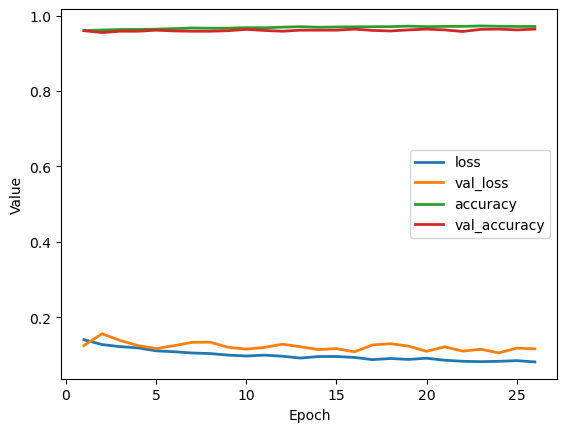

In [38]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [39]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
report.save('-ft')

 1/56 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step


 1/56 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step


Report saved as Output/Reports/AP2/report_full_BO1ID6QX.html


In [40]:
# END

In [41]:
######################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################